In [1]:
!python --version

Python 3.8.13


# Extract Time Series Sentinel-2 data
## from Digital Earth Australia (DEA) via STAC

In [2]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr

import pystac_client
import odc.stac
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

from datacube.utils.geometry import CRS, Geometry, BoundingBox
from datacube.model import GridSpec

# My helper class
from helperfunctions import begin_timer, end_timer, saveDataset, loadDataset
from dea_helperfunctions import DEA_HelperFunctions

from dea_tools.plotting import rgb, map_shapefile

### Constants

In [3]:
# Coordinate Reference Systems (CRS)
# !! ENSURE YOU USING CONSISTENT CRS WHEN PLOTTING AREAS OR PERFORMING GEOMETRIC OPERATIONS.
epsg4326 = 'epsg:4326'            # EPSG:4326 | WGS84 latitude-longitude CRS | in Degrees of Latitude and Longitude
epsg3577 = 'epsg:3577'            # EPSG:3577 | GDA94 / Australian Albers projection | in Metres from CRS Centroid

cropregions_geojsonfile = '../datasets/crop_regions.json'

# configure helper functions
dea_fns = DEA_HelperFunctions()
basepath = "../datasets/"
fileextn = ".pkl"

filespecifier = "2016First15Days/"

### Extract and plot Survey area tiles

In [4]:
#Extract GeoDataFrame containing polygons
gdf_surveyarea = loadDataset(basepath + filespecifier + "tilepolygons" + fileextn)
print(gdf_surveyarea.crs)
gdf_surveyarea.head(5)

epsg:3577


,tile,geometry
0,1,"POLYGON ((587352.715 -3795648.621, 587610.746 ..."
1,2,"POLYGON ((592458.349 -3795907.007, 592718.624 ..."
2,3,"POLYGON ((597563.870 -3796167.629, 597826.388 ..."
3,4,"POLYGON ((602669.277 -3796430.487, 602934.037 ..."
4,5,"POLYGON ((607774.568 -3796695.581, 608041.570 ..."


In [5]:
map_centroid = [-34.62929501472954, 138.43196647747274] # PortGawlerBeach, SA
map_zoom_level = 8

m = gdf_surveyarea.explore( 
     column="tile", # make choropleth based on Commodity description
     tooltip=["tile"],
     popup=True, # show all values in popup (on click)
     tiles="OpenStreetMap", # use "CartoDB positron" tiles
     cmap="Wistia", # use "Set1" matplotlib colormap
     legend=False,
     location=map_centroid,
     zoom_start = map_zoom_level,
     name='Survey Area Tiles' )

folium.TileLayer('CartoDB positron', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  # show map

### Extract initial dataset and plot cloud free days

In [114]:
surveyarea_initds = [] # [timeband, tile number, polygon, dataset]
surveyarea_initds = loadDataset(basepath + filespecifier + "initialdataset" + fileextn)

In [115]:
# matrix plot of tile count
numoftiles = 50
tiles = list(range(1,numoftiles+1))
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create custom colour map
from matplotlib.colors import LinearSegmentedColormap
cmBlkBlue8 = LinearSegmentedColormap.from_list('BlkBlue8', [(0, 0, 0), (0, 128/255, 224/255)], N=8)

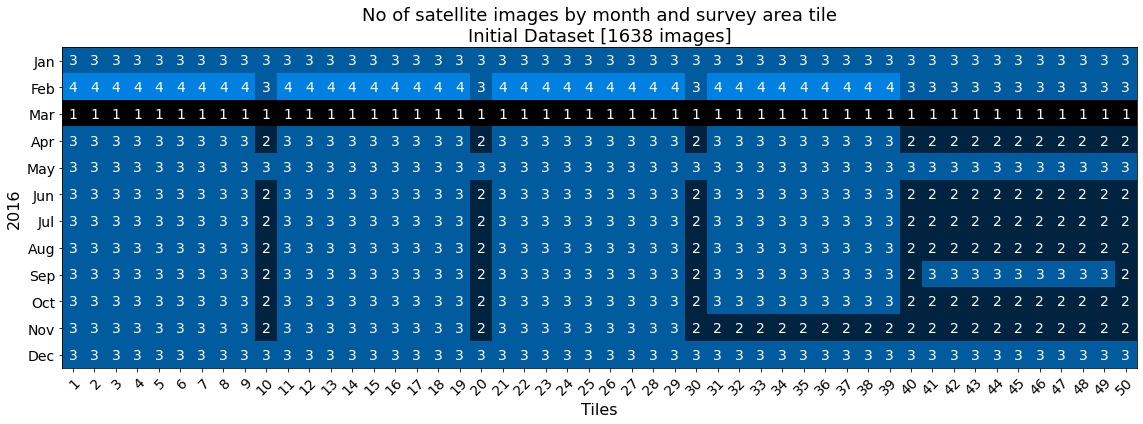

In [127]:
tc_matrix = np.zeros((12, numoftiles), dtype=int)
for i in range(12):
    for j in range(numoftiles):
        surveyarea_filter2 = filter(lambda ds: (ds[4] == j+1) & (ds[2] == i+1), surveyarea_initds)
        surveyareatilesets = list(surveyarea_filter2) # create a list of xarray.DataSets for this tileset
        if len(list(surveyareatilesets))>0:
            tc_matrix[i, j] = surveyareatilesets[0][6].time.shape[0] # extract number of images in this tileset
        else:
            tc_matrix[i, j] = 0
            
total_num_images = tc_matrix.sum()

# Plot matrix
fig, ax = plt.subplots(figsize=(16,6))
im = ax.imshow(tc_matrix, cmap = cmBlkBlue8, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tiles)), labels=tiles, fontsize=14)
ax.set_yticks(np.arange(len(months)), labels=months, fontsize=14)
ax.set_xlabel('Tiles', fontsize=16)
ax.set_ylabel('2016', fontsize=16)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(months)):
    for j in range(len(tiles)):
        text = ax.text(j, i, tc_matrix[i, j],
                       ha="center", va="center", color="w", fontsize=14)
ax.set_title(f"No of satellite images by month and survey area tile\nInitial Dataset ["
              + str(total_num_images) + " images]", fontsize=18)
fig.tight_layout()
plt.savefig(basepath + filespecifier + 'ImageCountMatrixPlot_initialdataset.png')

### Extract final dataset and plot cloud free days and survey area

In [117]:
surveyarea_ds = [] # [timeband, tile number, polygon, dataset]
surveyarea_ds = loadDataset(basepath + filespecifier + "dataset" + fileextn)

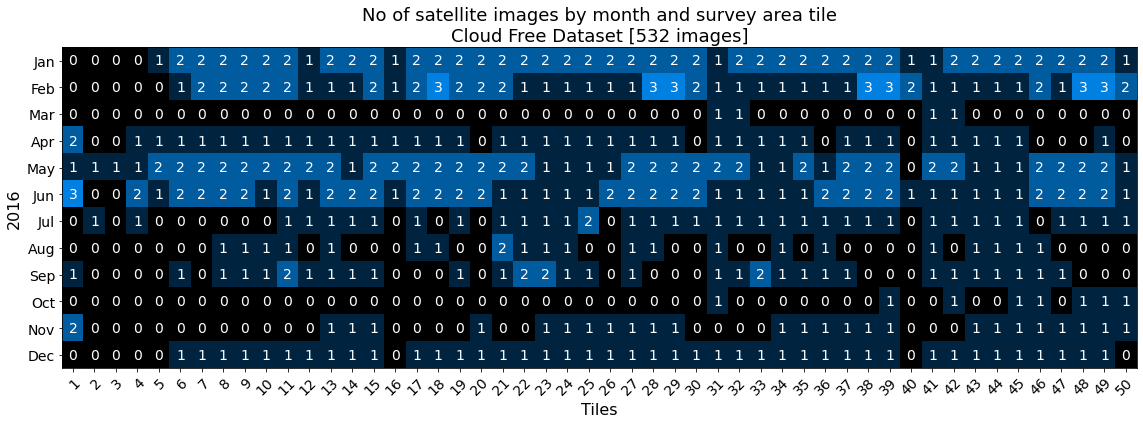

In [128]:
tc_matrix = np.zeros((12, numoftiles), dtype=int)
for i in range(12):
    for j in range(numoftiles):
        surveyarea_filter2 = filter(lambda ds: (ds[4] == j+1) & (ds[2] == i+1), surveyarea_ds)
        surveyareatilesets = list(surveyarea_filter2) # create a list of xarray.DataSets for this tileset
        if len(list(surveyareatilesets))>0:
            tc_matrix[i, j] = surveyareatilesets[0][6].time.shape[0] # extract number of images in this tileset
        else:
            tc_matrix[i, j] = 0

total_num_images = tc_matrix.sum()

# Plot matrix
fig, ax = plt.subplots(figsize=(16,6))
im = ax.imshow(tc_matrix, cmap = cmBlkBlue8, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tiles)), labels=tiles, fontsize=14)
ax.set_yticks(np.arange(len(months)), labels=months, fontsize=14)
ax.set_xlabel('Tiles', fontsize=16)
ax.set_ylabel('2016', fontsize=16)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(months)):
    for j in range(len(tiles)):
        text = ax.text(j, i, tc_matrix[i, j],
                       ha="center", va="center", color="w", fontsize=14)
ax.set_title(f"No of satellite images by month and survey area tile\nCloud Free Dataset ["
              + str(total_num_images) + " images]", fontsize=18)
fig.tight_layout()
plt.savefig(basepath + filespecifier + 'ImageCountMatrixPlot_dataset.png')

In [6]:
# COUNT OF DATASETS BY TILE THEN MONTH

print(' TILE | NUMBER OF DATASETS')
print('      | TOTAL | JAN | FEB | MAR | APR | MAY | JUN | JUL | AUG | SEP | OCT | NOV | DEC |')
print('='*87)
print(f'TOTAL | {len(list(surveyarea_ds)):5d} |',end='')
for i in range(12):
    surveyarea_filter = filter(lambda ds: (ds[2] == i+1), surveyarea_ds)
    print(f' {len(list(surveyarea_filter)):2d}  |', end='')
print()
print('-'*87)
for i in range(50):
    surveyarea_filter = filter(lambda ds: (ds[4] == i+1), surveyarea_ds)
    print(f'  {(i+1):2d}  |  {len(list(surveyarea_filter)):3d}  |', end='')
    
    for j in range(12):
        surveyarea_filter2 = filter(lambda ds: (ds[2] == j+1) & (ds[4] == i+1), surveyarea_ds)
        print(f' {len(list(surveyarea_filter2)):3d} |', end='')
    print()
print('='*87)


 TILE | NUMBER OF DATASETS
      | TOTAL | JAN | FEB | MAR | APR | MAY | JUN | JUL | AUG | SEP | OCT | NOV | DEC |
TOTAL |   396 | 46  | 45  |  4  | 40  | 49  | 48  | 36  | 21  | 31  |  8  | 26  | 42  |
---------------------------------------------------------------------------------------
   1  |    5  |   0 |   0 |   0 |   1 |   1 |   1 |   0 |   0 |   1 |   0 |   1 |   0 |
   2  |    2  |   0 |   0 |   0 |   0 |   1 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |
   3  |    1  |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
   4  |    4  |   0 |   0 |   0 |   1 |   1 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |
   5  |    4  |   1 |   0 |   0 |   1 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
   6  |    7  |   1 |   1 |   0 |   1 |   1 |   1 |   0 |   0 |   1 |   0 |   0 |   1 |
   7  |    6  |   1 |   1 |   0 |   1 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   1 |
   8  |    8  |   1 |   1 |   0 |   1 |   1 |   1 |   0 |   1 |   1 |   0 |   0 |   1 |
   9 

### Plot NIR and Additional Band Indices

In [7]:
# Extract all images for a specific Tile
t = 45 # tile number
surveyarea_filter = filter(lambda ds: (ds[4] == t), surveyarea_ds)

surveyarea_tiles = list(surveyarea_filter)
num_ds = len(surveyarea_tiles)

surveyarea_tiles[6]

[['2016-08-01', '2016-08-15'],
 2016,
 8,
 4,
 45,
 BoundingBox(left=608842.7464084815, bottom=-3776478.614512081, right=614226.2503610562, top=-3771088.300424647),
 <xarray.Dataset>
 Dimensions:      (time: 1, y: 512, x: 512)
 Coordinates:
   * time         (time) datetime64[ns] 2016-08-13T00:56:07.021000
   * y            (y) float64 -3.776e+06 -3.776e+06 ... -3.782e+06 -3.782e+06
   * x            (x) float64 6.088e+05 6.089e+05 ... 6.139e+05 6.14e+05
     spatial_ref  int32 3577
 Data variables: (12/19)
     nbart_blue   (time, y, x) uint16 439 421 413 429 459 ... 623 573 522 570 578
     nbart_green  (time, y, x) uint16 776 760 757 756 785 ... 949 908 857 938 887
     nbart_red    (time, y, x) uint16 883 797 841 882 867 ... 1026 906 989 958
     nbart_nir_1  (time, y, x) uint16 2626 2576 2488 2548 ... 3119 3188 3271 3268
     fmask        (time, y, x) uint16 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
     NDVI         (time, y, x) float64 0.4967 0.5274 0.4947 ... 0.5357 0.5466
  

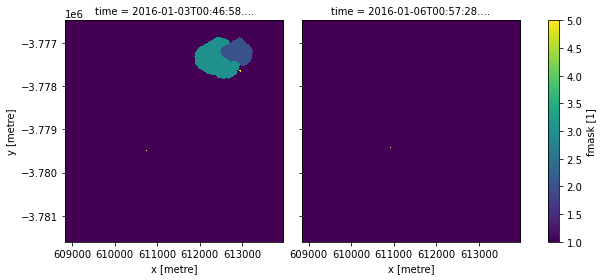

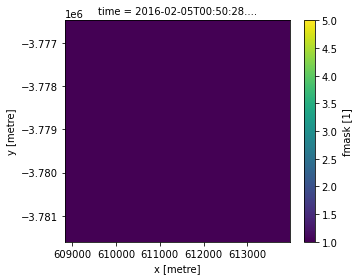

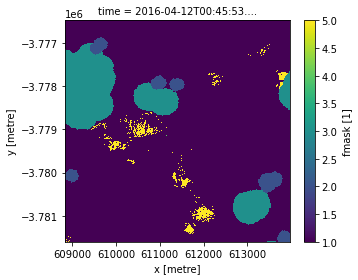

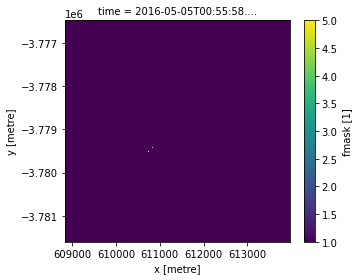

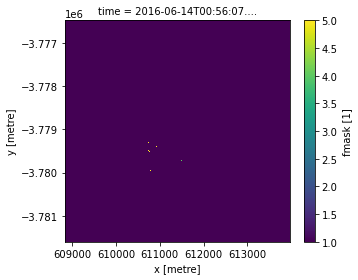

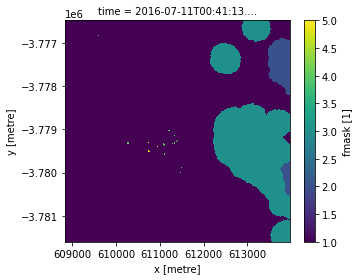

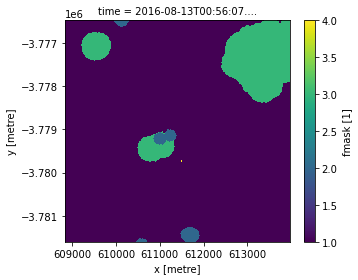

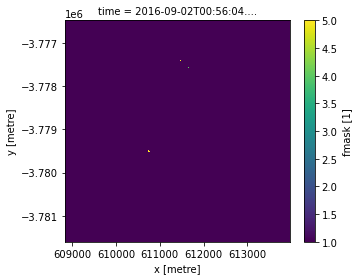

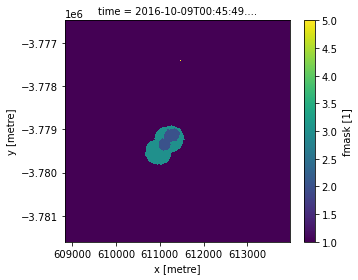

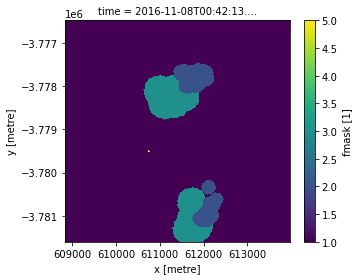

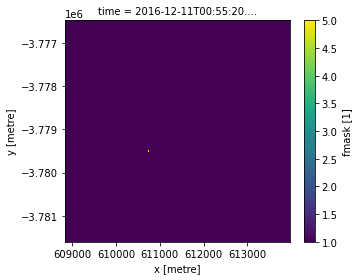

In [12]:
# Show Satellite images for selected tile
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    fig = xr.plot.imshow(ds.fmask, col="time", add_colorbar=True, size=4)

## Plot NIR-G-B

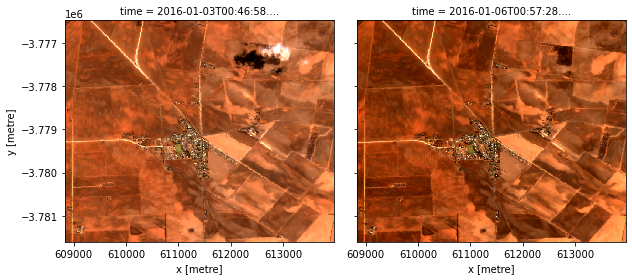

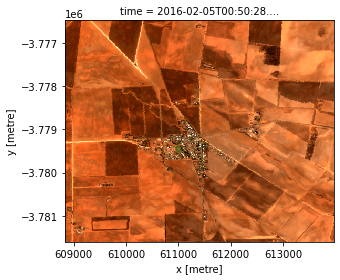

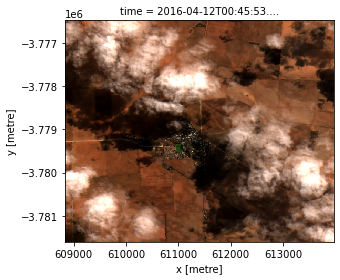

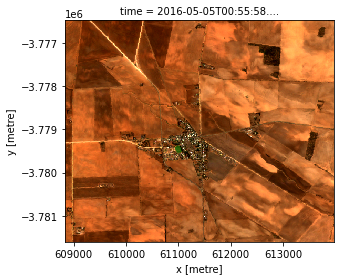

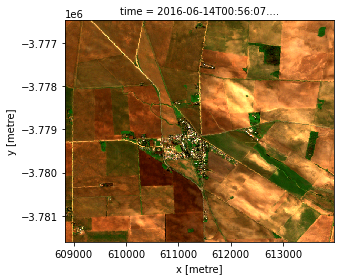

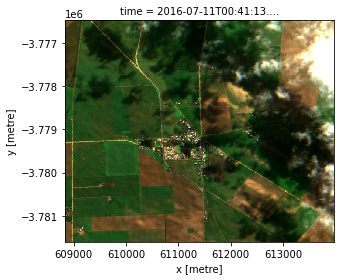

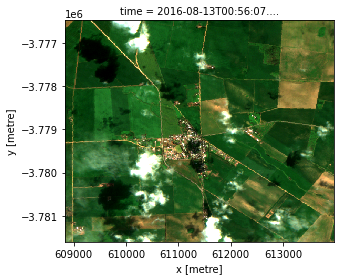

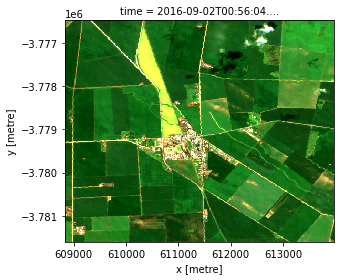

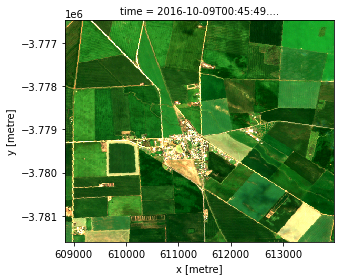

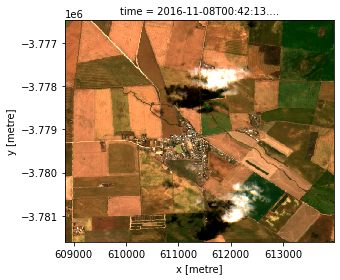

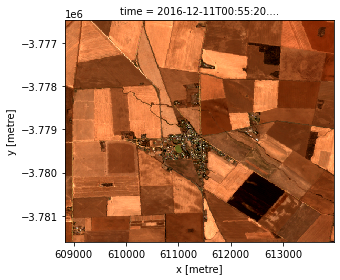

In [9]:
# Show Satellite images for selected tile
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    rgb(ds, bands=['nbart_red', 'nbart_green', 'nbart_blue'], col="time", size=4)